In [15]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
import matplotlib.gridspec as gridspec
import time
import scipy.stats as st

In [39]:
# Modelo lineal
def model(x, m, c):
    ''' A straight line model: y = m*x + c '''
    return m*x + c

In [17]:
m_true = 3.5 # gradient of the line
c_true = 1.2 # y-intercept of the line

In [18]:
L = 1. #Range of x-data
M = 100 # Number of data points
x = np.sort(L * np.random.rand(M)) # their x-coordinates

In [40]:
sigma = 0.5 # standard deviation of the noise
data = model(x, m_true, c_true) + sigma * np.random.randn(M)


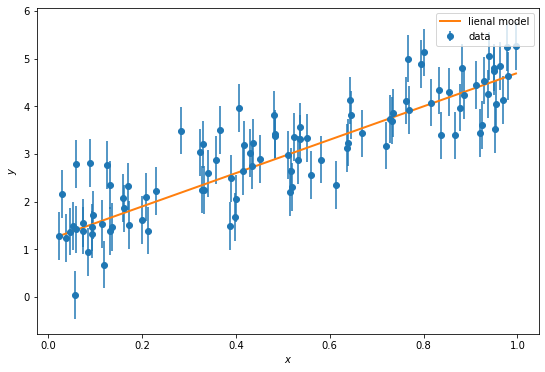

In [20]:
plt.figure(figsize=(9,6))
plt.errorbar(x, data, yerr=sigma, fmt="o", label='data')
plt.plot(x, straight_line(x, m_true, c_true), '-', lw=2, label='lienal model')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

In [21]:
def logprior(theta):
    prior = 0
    m, c = theta
    clims = [-10,10]
    mlims = [-10,10]
    prior = 0 if clims[0] < c < clims[1] else -np.inf
    prior += 0 if mlims[0] < m < mlims[1] else -np.inf
    return prior

In [22]:
def likelihood(theta, data, sigma, x):
    c,m = theta
    lin_md = model(x, m, c)
    difDatos = lin_md - data
    arg = difDatos/sigma**2
    loglikelihood = -0.5 * np.sum(arg)
    return loglikelihood

In [23]:
def logpost(theta, data, sigma, x):
    return logprior(theta) + likelihood(theta, data, sigma, x)

In [24]:
nwalkers = 10 # Number of walkers to use. It should be at least twice the number of dimensions.
nsteps = 5000 # Number of steps/iterations.
start = 0.01 * np.random.randn(nwalkers,2) # Initial positions of the walkers.
t0 = time.time()
samples = 0.01 * np.random.randn(len(x),2)


In [25]:
def guassian_posterior(X, theta):
    # returns the unnormalized log posterior
    loglik = likelihood(theta, X, sigma, x)
    logprior = np.log(st.norm(loc=0, scale=1).pdf(theta))
    
    return loglik + logprior
    
def guassian_proposal(theta_curr):
    # proposal based on Gaussian
    theta_new = st.norm(loc=theta_curr, scale=0.2).rvs()
    return theta_new

def guassian_proposal_prob(x1, x2):
    # calculate proposal probability q(x2|x1), based on Gaussian
    q = st.norm(loc=x1, scale=1).pdf(x2)
    return q

def mcmc_mh_posterior(X, theta_init,sigma,x,nwalkers,func, proposal_func, proposal_func_prob, n_iter=1000):
    # Metropolis-Hastings to estimate posterior
    chains = []
    for j in range(nwalkers):
        thetas = []
        theta_curr = theta_init[j]
        accept_rates = []
        accept_cum = 0
        
        for i in range(1, n_iter+1):
            print(i)
            theta_new = proposal_func(theta_curr)
            prob_curr = func(theta_curr,X,sigma,x)
            prob_new = func(theta_new,X,sigma,x)
            if prob_new > prob_curr:
                acceptance_ratio = 1,1
            else:
                qr = proposal_func_prob(theta_curr, theta_new)/proposal_func_prob(theta_curr, theta_new)
                
                acceptance_ratio = np.exp(prob_new - prob_curr) * qr
            print('accRatio1',acceptance_ratio)
            acceptance_prob = min(1, acceptance_ratio[0]),min(1, acceptance_ratio[1])
            
            if acceptance_prob[0] > st.uniform(0,1).rvs() and acceptance_prob[1] > st.uniform(0,1).rvs():
                theta_curr = theta_new
                accept_cum = accept_cum+1
                thetas.append(theta_new)
            else:
                thetas.append(theta_curr)
                
            accept_rates.append(accept_cum/i)
        chains.append(thetas)
        
    return chains


# generate observed data
X = data
nwalkers = 10
ndim = 2
cmin = .5
cmax = 1.5
mmin = 2
mmax = 5
initSamples = [ np.random.randn(nwalkers,2)]

# run MCMC
thetas, accept_rates = mcmc_mh_posterior(X, initSamples[0],sigma,x, nwalkers,
                                         logpost, guassian_proposal, guassian_proposal_prob, 
                                         n_iter=1000)


1
[-0.51286083  0.44504581]
[-0.55864659 -0.00835558]
probCur -2397.055494582899
prob_new -2822.158263106384
accRatio1 [2.40001186e-185 2.40001186e-185]
2
[-0.51286083  0.44504581]
[-0.66720101  0.40243543]
probCur -2397.055494582899
prob_new -2639.211335053049
accRatio1 [6.80855144e-106 6.80855144e-106]
3
[-0.51286083  0.44504581]
[-0.34567012  0.37780608]
probCur -2397.055494582899
prob_new -2231.695882012921
accRatio1 (1, 1)
4
[-0.34567012  0.37780608]
[0.04409875 0.33269862]
probCur -2231.695882012921
prob_new -1799.221619568664
accRatio1 (1, 1)
5
[0.04409875 0.33269862]
[0.12605615 0.57530857]
probCur -1799.221619568664
prob_new -1554.7679011766054
accRatio1 (1, 1)
6
[0.12605615 0.57530857]
[0.57927332 0.58159118]
probCur -1554.7679011766054
prob_new -1122.689699726963
accRatio1 (1, 1)
7
[0.57927332 0.58159118]
[0.74797055 0.71266874]
probCur -1122.689699726963
prob_new -920.5973827752495
accRatio1 (1, 1)
8
[0.74797055 0.71266874]
[0.98052929 0.79593078]
probCur -920.5973827752495

In [26]:
m_theta = []
c_theta = []
chains = []
for i in range(nwalkers):
    m_theta = []
    c_theta = []
    for j in range(len(thetas[0])):
        c_theta.append(thetas[i][j][0])
        m_theta.append(thetas[i][j][1])
    chains.append([c_theta,m_theta]) 

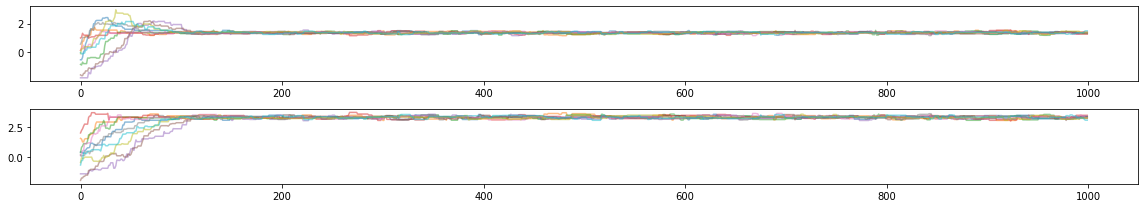

In [27]:


plt.figure(figsize=(16,1.5*ndim))

for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    for i in range(nwalkers):
        plt.plot(chains[i][n][:], '-',alpha=0.5)
plt.tight_layout()
plt.show()

In [36]:
import seaborn as sns
import pandas
m = []
c = []
for i in range(len(chains[0][0])):
    meanM = []
    meanC = []
    for j in range(nwalkers):
        meanM.append(chains[j][1][i])
        meanC.append(chains[j][0][i])
    m.append(np.mean(meanM))
    c.append(np.mean(meanC))
m_fit = max(m)
c_fit = max(c) 
print(m_fit)

d = {'c': c, 'm': m}
c_fit = max(d['c']) 
chainData = pandas.DataFrame(d)
c_fit = np.percentile(chainData['c'].to_numpy(), 50)
m_fit = np.percentile(chainData['m'].to_numpy(), 50)


3.415516417112493


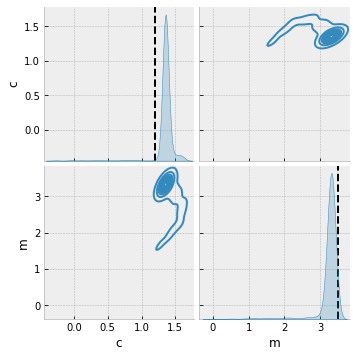

In [31]:
#sns.pairplot(chainData, kind="kde")
plt.style.use('bmh')
g = sns.pairplot(chainData, kind="kde")
i = 0
for ax in g.axes.ravel():
    if i == 0: ax.axvline(x=c_true, ls='--', linewidth=2, c='black',label='True c')
    if i == 3: ax.axvline(x=m_true, ls='--', linewidth=2, c='black',label='True m')
    i += 1
plt.show()


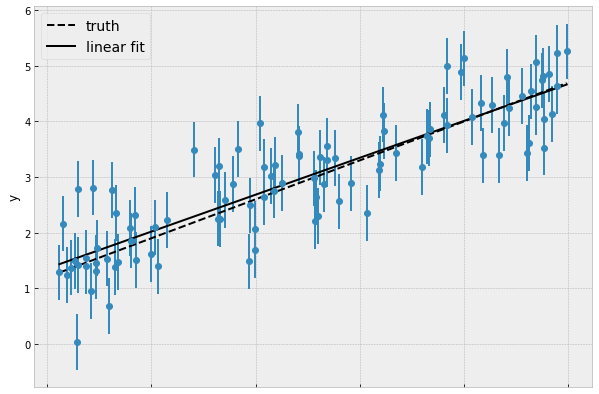

In [37]:
###
fig,ax1=plt.subplots(1,1,figsize=(10,7))
gs=gridspec.GridSpec(1,1)
colors=['b','orange']
###

ax1=plt.subplot(gs[0])
# inds = np.random.randint(len(chains[:][1]), size=100)
# for ind in inds:
#     sample = chains[ind]
#     ax1.plot(x, np.dot(np.vander(x, 2), sample[:2]),colors[0], alpha=0.1)

ax1.errorbar(x, data, yerr=sigma, fmt="o")
ax1.plot(x, straight_line(x,m_true,c_true), 'k--', label="truth")
ax1.plot(x, straight_line(x,m_fit,c_fit), 'k', label="linear fit")


###

ax1.legend(fontsize=14)
models = ['linear model', 'quadratic model']
ax1.set_ylabel(r'y')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)